In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install optuna

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


df = pd.read_csv('ex2.csv')
column_names = ['Unnamed: 0','participant_type', 'participant_status', 'incident_characteristics', 'notes', 'n_injured','incident_id', 'gun_stolen', 'gun_type', 'location_description','address', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name', 'participant_relationship']
df = df.drop(columns=column_names)
df

,date,state,city_or_county,n_killed,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
0,2017-06-25,California,Humboldt County (county),0,2.0,40.7450,-123.8700,1.0,2.0,2.0
1,2015-12-15,Georgia,Gwinnett (county),0,7.0,33.9997,-84.0148,1.0,102.0,45.0
2,2017-11-04,North Carolina,Rocky Mount,0,2.0,35.9934,-77.8066,1.0,7.0,4.0
3,2016-08-11,Texas,Odessa,0,11.0,31.8876,-102.3410,5.0,81.0,31.0
4,2015-05-30,New York,Amityville,1,2.0,40.6923,-73.4185,NaN,11.0,8.0
...,...,...,...,...,...,...,...,...,...,...
29995,2015-06-14,Georgia,Grovetown,0,12.0,33.4554,-82.2044,1.0,121.0,23.0
29996,2014-11-11,New York,Yonkers,0,16.0,40.9401,-73.8890,1.0,90.0,35.0
29997,2014-10-31,Washington,Roy,0,10.0,47.0030,-122.5430,NaN,2.0,2.0
29998,2018-03-26,Virginia,Newport News,0,3.0,36.9959,-76.4245,1.0,95.0,2.0


I removed:

* columns that are not relevant to the prediction of the number of killed.

* columns which could lead to data leakage.

Spliting the date column into three new columns - year, mounth and day:

In [117]:
df[['year', 'month', 'day']] = df['date'].str.split('-', expand=True)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)
df = df.drop(columns='date')
df

,state,city_or_county,n_killed,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district,year,month,day
0,California,Humboldt County (county),0,2.0,40.7450,-123.8700,1.0,2.0,2.0,2017,6,25
1,Georgia,Gwinnett (county),0,7.0,33.9997,-84.0148,1.0,102.0,45.0,2015,12,15
2,North Carolina,Rocky Mount,0,2.0,35.9934,-77.8066,1.0,7.0,4.0,2017,11,4
3,Texas,Odessa,0,11.0,31.8876,-102.3410,5.0,81.0,31.0,2016,8,11
4,New York,Amityville,1,2.0,40.6923,-73.4185,NaN,11.0,8.0,2015,5,30
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Georgia,Grovetown,0,12.0,33.4554,-82.2044,1.0,121.0,23.0,2015,6,14
29996,New York,Yonkers,0,16.0,40.9401,-73.8890,1.0,90.0,35.0,2014,11,11
29997,Washington,Roy,0,10.0,47.0030,-122.5430,NaN,2.0,2.0,2014,10,31
29998,Virginia,Newport News,0,3.0,36.9959,-76.4245,1.0,95.0,2.0,2018,3,26


Spliting the data to train, test and validation.
And removing samples with null in the label.

In [118]:
df = df.dropna(subset=['n_killed'])
df.reset_index(drop=True, inplace=True)
X = df.drop(columns='n_killed')
y = df['n_killed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

Calculate the mode for all the columns in the tain:

In [119]:
def latitude_mode(x):
  filtered_data = X_train.loc[(df[x] >= -90) & (X_train[x] <= 90), x]
  mode_result = filtered_data.mode()[0]
  return mode_result

def longitude_mode(x):
  filtered_data = X_train.loc[(df[x] >= -180) & (X_train[x] <= 180), x]
  mode_result = filtered_data.mode()[0]
  return mode_result

In [120]:
train_mode_col = {}

for col in X_train:
    train_mode_col[col] = df[col].dropna().mode()[0]
    if col == 'latitude':
      train_mode_col[col] = latitude_mode('latitude')
    if col == "longitude":
      train_mode_col[col] = longitude_mode('longitude')
train_mode_col

{'state': 'Illinois',
 'city_or_county': 'Chicago',
 'congressional_district': 1.0,
 'latitude': 39.294,
 'longitude': -76.62,
 'n_guns_involved': 1.0,
 'state_house_district': 10.0,
 'state_senate_district': 5.0,
 'year': 2017,
 'month': 1,
 'day': 1}

Change all the null values in the fatures of each set to the mode value in the train:

In [121]:
for col in X_train:
    X_train[col].fillna(train_mode_col[col], inplace=True)
    X_test[col].fillna(train_mode_col[col], inplace=True)
    X_val[col].fillna(train_mode_col[col], inplace=True)


In [122]:
X_train_before_one_hot = X_train.copy()

In [123]:
X_test_before_one_hot = X_test.copy()

Activate one hot encoding to all the categorical features in each set:

In [124]:
def one_hot(train_df, test_df, val_df, column_name, prefix=None):
    onehot_encoder = OneHotEncoder(handle_unknown='ignore')

    column_data_train = train_df[[column_name]]
    onehot_encoder.fit(column_data_train)

    for df in [train_df, test_df, val_df]:
        column_data = df[[column_name]]
        new_columns = onehot_encoder.transform(column_data)
        new_column_names = [prefix + str(category) for category in onehot_encoder.categories_[0]]
        new_columns_df = pd.DataFrame(new_columns.toarray(), columns=new_column_names, index=df.index)
        df[new_column_names] = new_columns_df
        df.drop(columns=[column_name], inplace=True)

    return train_df, test_df, val_df


X_train, X_test, X_val = one_hot(X_train, X_test, X_val, 'state', prefix='state')
X_train, X_test, X_val = one_hot(X_train, X_test, X_val, 'city_or_county', prefix='city')
X_train, X_test, X_val = one_hot(X_train, X_test, X_val, 'congressional_district', prefix='congressional')
X_train, X_test, X_val = one_hot(X_train, X_test, X_val, 'state_senate_district', prefix='state_senate')
X_train, X_test, X_val = one_hot(X_train, X_test, X_val, 'state_house_district', prefix='state_house')

Streaming output truncated to the last 5000 lines.
<ipython-input-124-b1b3cc71ec26>:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-124-b1b3cc71ec26>:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-124-b1b3cc71ec26>:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<

# 1.

SVM

In [ ]:
default_SVM_model = SVR()
default_SVM_model.fit(X_train, y_train)
y_pred = default_SVM_model.predict(X_test)
y_pred = np.round(y_pred)

rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.5472659317004851


RandomForest

In [ ]:
default_model = RandomForestRegressor(random_state=42,n_jobs=-1)
default_model.fit(X_train, y_train)
y_pred = default_model.predict(X_test)
y_pred = np.round(y_pred)

rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.5678908345800273


**The modles I chose** -


Our problem is regression because we need to predict the oridinal feature - 'n_killed'.

This is not classification problem because the number can be any integer and it not related to a closed group of values.
RandomForestRegressor and SVR are models for regression problem.


**Advantage for RandomForestRegressor**:

Random Forest is an ensemble learning method that combines the predictions of multiple decision trees to produce more accurate predictions.

 By averaging the predictions of individual trees, Random Forest reduces overfitting and improves generalization performance.


**Disadvantage for RandomForestRegressor**:

RandomForestRegressor can take longer to train compared to simpler models like linear regression, especially when the dataset is large and/or has many predictors. This is because RandomForestRegressor builds multiple decision trees, and each tree can potentially be complex, leading to longer training times.




**Advantage for SVR**:

 SVR is less prone to overfitting, particularly in situations where the number of features exceeds the number of samples



**Disatvantage for SVR**:

SVR performance is highly sensitive to the choice of hyperparameters such as the regularization parameter (C) and kernel parameters, which need to be tuned carefully.

**The metric I chose is RMSE**:

I want to penalize large errors significantly, because if for example there are many killed people and the prediction is very small Mada would send few ambulances instaed of many.

MAE is less influnce from outliers so it wont penalize large errors.

It preferred to use the RMSE over MSE as it will be in the original units of the response variable, which might be more interpretable.

 R2 tells us how well the predictor variables can explain the variation in the response variable,

but with RMSE we explicitly know how much our predictions deviate, on average, from the actual values in the dataset.


I trained the models with their default hyper-parameters and got:

RMSE for RandomForestRegressor : 0.5678908345800273
RMSE for SVR : 0.5472659317004851

In the next questions I will continue to work with RandomForestRegressor.

# 2.

The hyperparameters I chose to optimize over are:

n_estimators, max_depth, min_samples_leaf, min_samples_split.

In the GridSearchCV method the best hyperparameters found are -

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 10}
With RMSE of : 0.5019750026009714

 With optuna the best hyperparameters found are -

 {'n_estimators': 20, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 8}

  With RMSE of :0.5579725202313581 on the validation

After training with the hyperparameters:
  {'n_estimators': 12, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 8}




In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## RandomForestRegressor:

In [ ]:
model = RandomForestRegressor()
params_grid = {
    'n_estimators': [2, 15, 20],
    'max_depth': [None, 10],
    'min_samples_leaf': [2, 8],
    'min_samples_split': [2, 7]
}

grid_search = GridSearchCV(model, params_grid, cv=3, scoring=make_scorer(root_mean_squared_error, greater_is_better=False), n_jobs=-1)

scale_transform = scaler.fit_transform(X_train)
grid_search.fit(scale_transform, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)





Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 10}


In [ ]:
print('Best parameters found in Grid Search', grid_search.best_params_)
print('Best score in Grid Search', -grid_search.best_score_)
model_gs = grid_search.best_estimator_

Best parameters found in Grid Search {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 10}
Best score in Grid Search 0.5019750026009714


## optuna:

In [96]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',5, 20)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 15])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    y_pred = np.round(y_pred)
    rmse = root_mean_squared_error(y_val, y_pred)

    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-02-15 13:12:16,148] A new study created in memory with name: no-name-200a0405-1646-4cf2-a9d7-0e3212131bd8
[I 2024-02-15 13:12:25,145] Trial 0 finished with value: 0.5633234713140696 and parameters: {'n_estimators': 8, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5633234713140696.
[I 2024-02-15 13:12:52,812] Trial 1 finished with value: 0.5579725202313581 and parameters: {'n_estimators': 20, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.5579725202313581.
[I 2024-02-15 13:13:36,769] Trial 2 finished with value: 0.5907622195096771 and parameters: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.5579725202313581.
[I 2024-02-15 13:13:49,260] Trial 3 finished with value: 0.5597618541248889 and parameters: {'n_estimators': 13, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1 with value:

Best Hyperparameters: {'n_estimators': 20, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 8}


In [97]:
best_n_estimators =20
best_max_depth = None
best_min_samples_split = 6
best_min_samples_leaf = 8

# 3.

## a.


   When training with the best hyperparameters

  The RMSE over the test is: 0.5521171373298726


In [126]:
best_model_origin = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42)
best_model_origin.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
y_pred = best_model_origin.predict(X_test_scaled)
y_pred = np.round(y_pred)

rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.5521171373298726


In [127]:
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances


plot_slice(study)

In [128]:
optuna.visualization.plot_param_importances(study)

  Feature importance visualization :

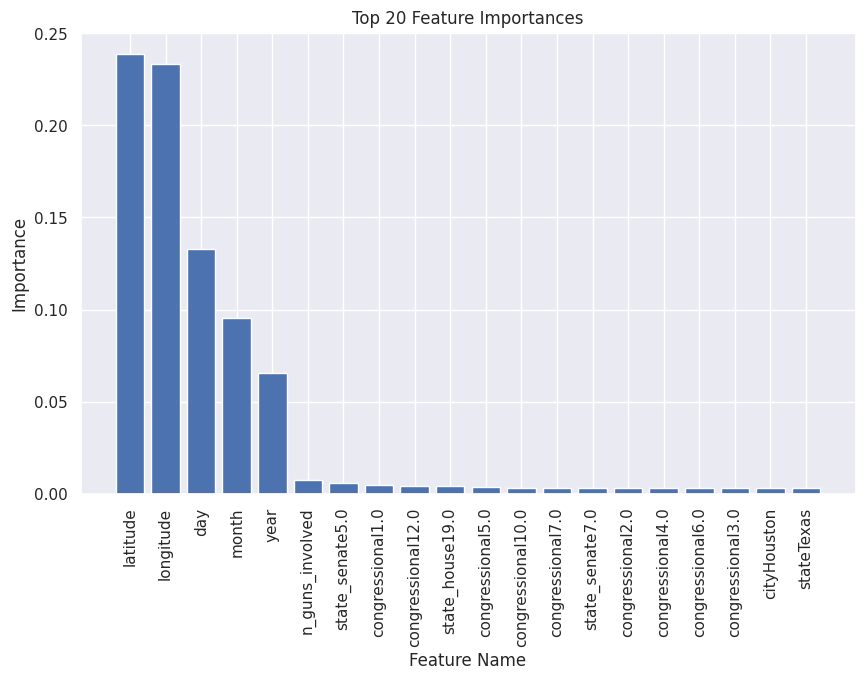

In [129]:
feature_importances = best_model_origin.feature_importances_

indices = np.argsort(feature_importances)[::-1]
top_indices = indices[:20]
top_importances = feature_importances[top_indices]
top_feature_names = X_test.columns[top_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(top_feature_names)), top_importances, color="b", align="center")
plt.xticks(range(len(top_feature_names)), top_feature_names, rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()


We can see that the most important feature are - 'latitude' and 'longitude'.

It make sense because the specific place where the crime occured can help us to predict the amount of pepole that killed because thre are more dangerous places than others or more populated places that the probability to have more killed peopole is higher.

Also year, day and nounth are important,

The crimes severity can change throughout time

and some mounth could be most of the time more problematic as a reslt of certain events that happen during the month or day.

## **b**

## Train without the top feature:

Origin RMSE 0.5521171373298726

RMSE for training without top important features : 0.5570756980279551


We can see that when we train without the most important feature the rmse is higer because we drop an important information.

The diff is small maybe because there are other features that can fill its place in a relatively similar way

In [131]:
scaler = StandardScaler()

X_train_without_top_feature = X_train.copy()
X_train_without_top_feature = X_train_without_top_feature.drop(columns="latitude")
X_test_without_top_feature = X_test.copy()
X_test_without_top_feature = X_test_without_top_feature.drop(columns="latitude")

X_train_scaled_without_top_feature_scaled = scaler.fit_transform(X_train_without_top_feature)
X_test_scaled__without_top_feature = scaler.transform(X_test_without_top_feature)

best_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42)

best_model.fit(X_train_scaled_without_top_feature_scaled, y_train)

y_pred_without_top = best_model.predict(X_test_scaled__without_top_feature)
y_pred_without_top = np.round(y_pred_without_top)

rmse = root_mean_squared_error(y_test, y_pred_without_top)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 0.5570756980279551


Feature importance after training without the top important feature :

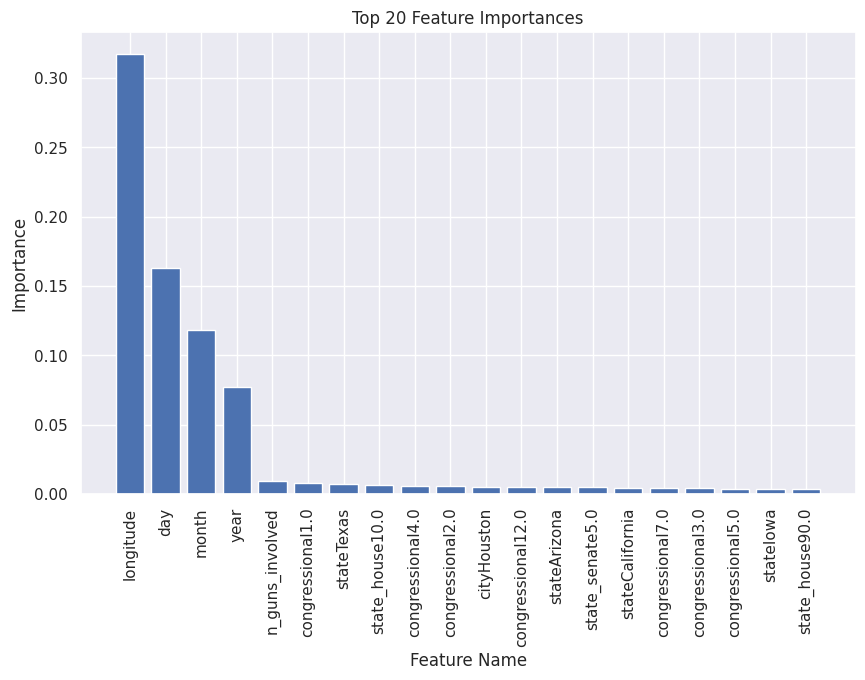

In [132]:
feature_importances = best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

top_indices = indices[:20]
top_importances = feature_importances[top_indices]
top_feature_names = X_test_without_top_feature.columns[top_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(top_feature_names)), top_importances, color="b", align="center")
plt.xticks(range(len(top_feature_names)), top_feature_names, rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()


## Train with only the four top features:

Origin RMSE :  0.5521171373298726
RMSE over the four top features :0.5546770832355225

We can see that when we train only on the top four important features, we got higher rmse probably as a result of training with only four features even if they are important features.
It makes the model learn about a smaller amount of information
And maybe hide a little amount of information that is also important.
this four features probably not enough for the model to learn, even though they have the most effect.



In [133]:
scaler = StandardScaler()

X_train_four_top_feature = X_train.copy()
X_train_four_top_feature = X_train_four_top_feature[['latitude','longitude','year','month']]
X_test_four_top_feature = X_test.copy()
X_test_four_top_feature = X_test_four_top_feature[['latitude','longitude','year','month']]

X_train_scaled_four_top_features = scaler.fit_transform(X_train_four_top_feature)
X_test_scaled_four_top_features = scaler.transform(X_test_four_top_feature)

best_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42)

best_model.fit(X_train_scaled_four_top_features, y_train)

y_pred_four_top = best_model.predict(X_test_scaled_four_top_features)
y_pred_four_top = np.round(y_pred_four_top)
rmse = root_mean_squared_error(y_test, y_pred_four_top)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 0.5546770832355225


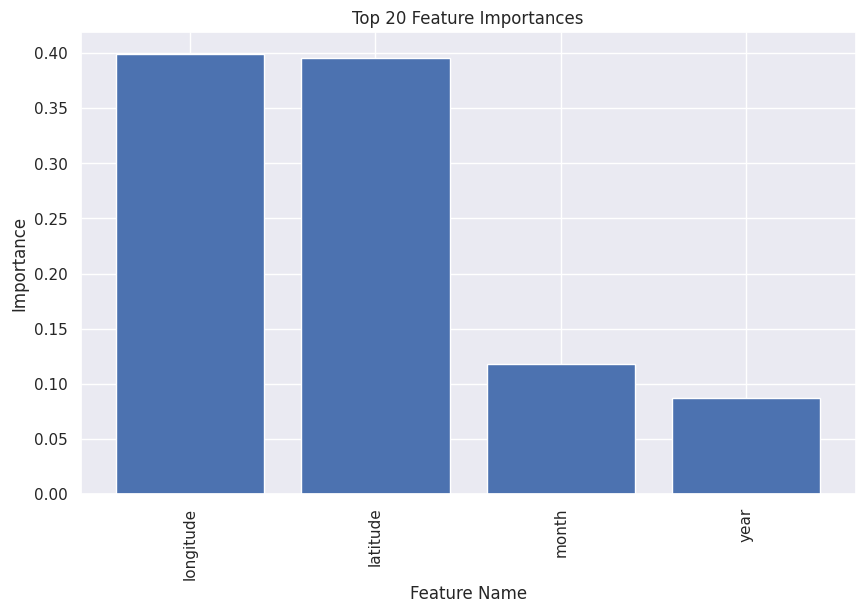

In [134]:
feature_importances = best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

top_indices = indices[:20]
top_importances = feature_importances[top_indices]
top_feature_names = X_test_four_top_feature.columns[top_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(top_feature_names)), top_importances, color="b", align="center")
plt.xticks(range(len(top_feature_names)), top_feature_names, rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()


## **4.**

Problematic data points exist,

There are sampels which the ensembels do not very much agree about them
and not got low decision variability.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: Use

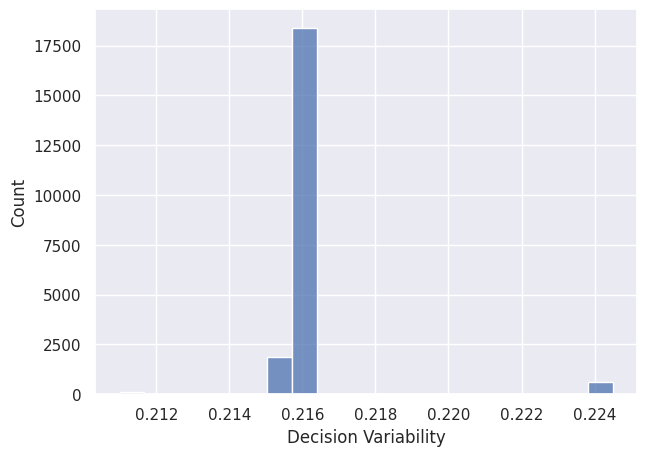

In [135]:
std_dev = np.vstack([i.predict(X_train) for i in best_model_origin.estimators_]).std(axis=0)
plt.figure(figsize=(7, 5))

sns.histplot(std_dev, bins=20)
plt.xlabel('Decision Variability')
plt.show()

In the bext printing we can see that most of the diff between the real label and the predicted label are 0, which means that the model were right in its most prediction.

 There are 16 samples in which the diff is bigger than 2 and since there are only 5 unique values for the diff, I will assume that those 16 samples are the most problematic data points.

In [136]:
diff = np.abs(y_test - y_pred)
rounded_diff = np.round(diff)
sorted_residuals = np.argsort(rounded_diff)
X_test['diff'] = rounded_diff
print(X_test['diff'].value_counts())


0.0    4560
1.0    1347
2.0      77
3.0      13
4.0       2
5.0       1
Name: diff, dtype: int64


My theory is that
Labels with the highest values in the test (5, 4 and also 3) are the hardest samples to predict,

as a result of the fact that the common labels in the train are 0 and 1 and there are not enough samples with higher labels  than 2.

In [137]:
X_test = X_test.drop(columns='diff')

5 top Samples that were the hardest to predict:

In [138]:
abs_diff =  abs(y_test - y_pred)
abs_diff_df = pd.DataFrame({'Absolute_Difference': abs_diff, 'Index': range(len(abs_diff))})
abs_diff_df_sorted = abs_diff_df.sort_values(by='Absolute_Difference', ascending=False)
hardest_samples = abs_diff_df_sorted.head(5)
print("Samples with the largest absolute differences:")
print(hardest_samples)

Samples with the largest absolute differences:
       Absolute_Difference  Index
24828                  5.0   3618
12596                  4.0   2699
8615                   4.0   5374
25126                  3.0   3872
27349                  3.0   1039


In the next plot we can see that in the train the most common labels are 0 and 1.
And there are few sampkes with labels 3 4 and 5.

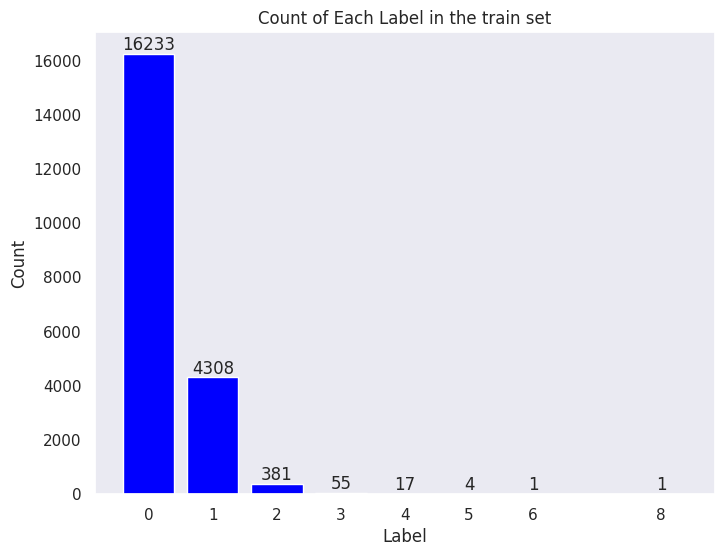

In [139]:

unique_labels, label_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, label_counts, color='blue')
for bar, count in zip(bars, label_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label in the train set')
plt.xticks(unique_labels)
plt.grid(False)
plt.show()

In the next plot over the test set we can see that there are only one label with the value 5 and four lables with the value 4 and there are not higher labels than those values.

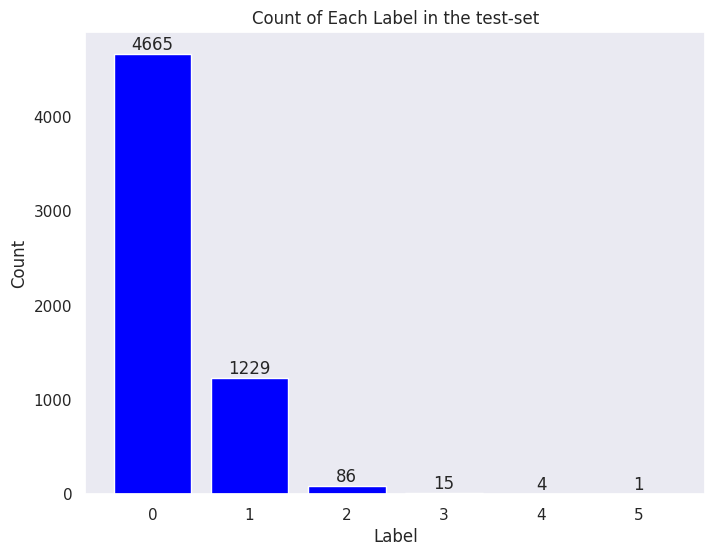

In [140]:

unique_labels, label_counts = np.unique(y_test, return_counts=True)
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, label_counts, color='blue')
for bar, count in zip(bars, label_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label in the test-set')
plt.xticks(unique_labels)
plt.grid(False)
plt.show()

Here we can see that the 5 most highet labels in the test are the five hardest to predict samples:

In [160]:
import numpy as np

largest_indices = np.argsort(y_test)[-5:]
largest_values = y_test.iloc[largest_indices]
print("Largest values in y_test:", largest_values)


Largest values in y_test: 6462     4
12596    4
8615     4
24371    4
24828    5
Name: n_killed, dtype: int64


In the next boxes we can see that the samples which were hardest to predict (the model had the bigggest mistake in their predication)
 are samples that  their label is more unique and very rare in the train set (5 and 4), so the model didnt show sufficient quantity of those values as a result it predict another value which is more similar to most of the data it learned, in this case a lower number.

 That cause the diff from the common value that was predicted -0
  to the real higer labels in the test set 5/4.

  It make sense that labels with the highest values in the test (5 and 4) are the hardest samples to predict.

In [154]:
print("Real label: " + str(+y_test[24828]))
print("Prediction label: " + str(y_pred[3618]))
print("Diff: " + str(y_test[24828] - y_pred[3618]))

Real label: 5
Prediction label: 0.0
Diff: 5.0


In [155]:
print("Real label: " + str(y_test[12596]))
print("Prediction label: " + str(y_pred[2699]))
print("Diff: " + str(y_test[12596] - y_pred[2699]))

Real label: 4
Prediction label: 0.0
Diff: 4.0


In [156]:
print("Real label: " + str(y_test[8615]))
print("Prediction label: " + str(y_pred[5374]))
print("Diff: " + str(y_test[8615] - y_pred[5374]))

Real label: 4
Prediction label: 0.0
Diff: 4.0


In [157]:
print("Real label: " + str(y_test[25126]))
print("Prediction label: " + str(y_pred[3872]))
print("Diff: " + str(y_test[25126] - y_pred[3872]))

Real label: 3
Prediction label: 0.0
Diff: 3.0


In [162]:
print("Real label: " + str(y_test[27349]))
print("Prediction label: " + str(y_pred[1039]))
print("Diff: " + str(y_test[27349] - y_pred[1039]))

Real label: 3
Prediction label: 0.0
Diff: 3.0


The five hardest to predict features values:

In [158]:
hardest_indices = hardest_samples['Index'].tolist()
hardest_samples_df = X_test_before_one_hot.iloc[hardest_indices]
print(hardest_samples_df)


                state     city_or_county  congressional_district  latitude  \
24828   West Virginia  Monongalia County                     1.0   39.6855   
12596            Ohio          Cleveland                    11.0   41.5180   
8615         Oklahoma              Tulsa                     1.0   36.0922   
25126    Pennsylvania      Osceola Mills                     5.0   40.8533   
27349  North Carolina          Morganton                    11.0   35.7342   

       longitude  n_guns_involved  state_house_district  \
24828   -79.8588              1.0                  51.0   
12596   -81.6234              1.0                  11.0   
8615    -95.7910              1.0                  75.0   
25126   -78.2732              1.0                  73.0   
27349   -81.7117              1.0                  86.0   

       state_senate_district  year  month  day  
24828                    2.0  2014     12    1  
12596                   21.0  2014     11   22  
8615                    36.0 

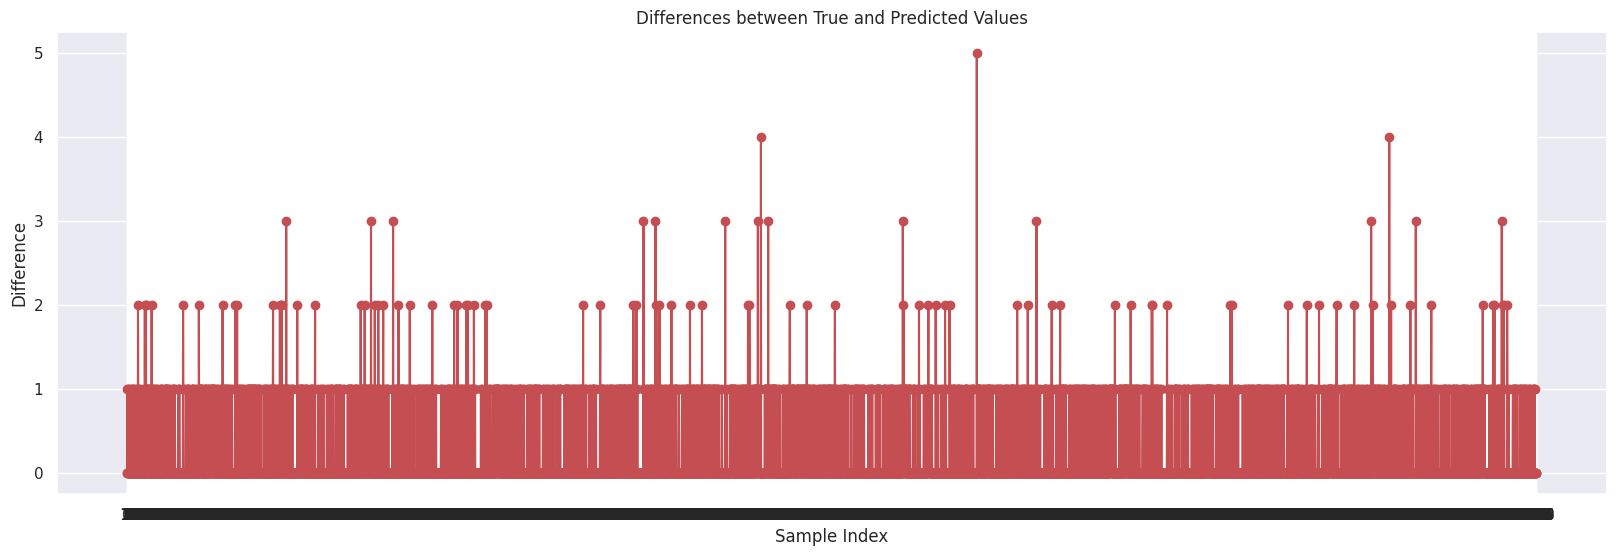

In [164]:
abs_diff =  abs(y_test - y_pred)
plt.figure(figsize=(20, 6))
plt.plot(range(len(y_test)), abs_diff, 'ro-')
plt.title('Differences between True and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.xticks(range(len(y_test)), range(len(y_test)))
plt.grid(True)
plt.show()


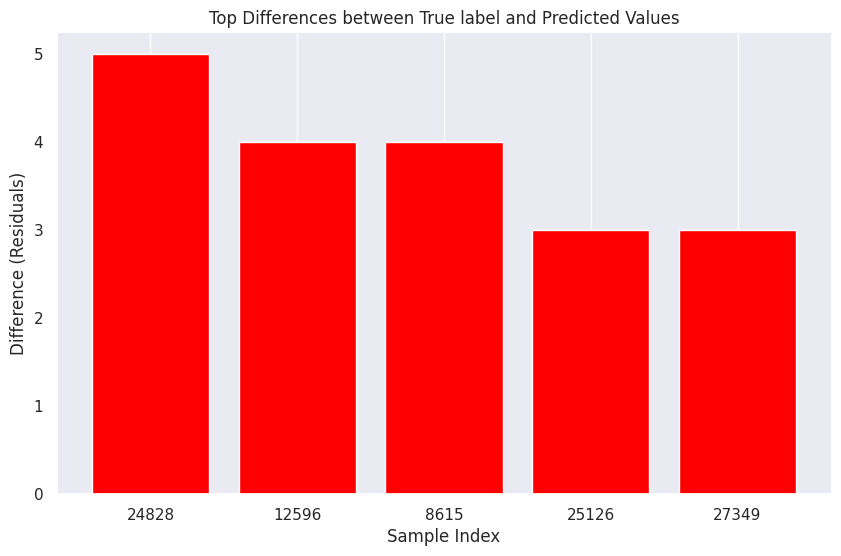

In [163]:
abs_diff = abs(y_test - y_pred)
top_sampled_numbers = [24828, 12596, 8615, 25126, 27349]
top_indices = [3618, 2699, 5374, 3872, 1039]
top_diff = abs_diff.iloc[top_indices]
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_diff)), top_diff, color='red')
plt.title('Top Differences between True label and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Difference (Residuals)')
plt.xticks(range(len(top_diff)), top_sampled_numbers)
plt.grid(axis='y')
plt.show()


In [165]:
pip list --format=freeze > requirements.txt